In [2]:
# import required modules
import numpy as np
import pandas as pd
from collections import Counter
import statistics

import random
import datetime
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from datetime import datetime, date

In [3]:
# import table from create_metadata_table.ipynb
allFactors = pd.read_csv("../data/metadata_matrix_raw.csv", low_memory=False)

In [4]:
# add a column with the total use count of each converted_accession ID

# first, create a new dataframe with no double-counted accessions
# justAcc includes all unique pairings of PMC ID and Series/Study accession
justAcc = allFactors.loc[:, ["pmc_ID", "converted_accession"]]
justAcc = justAcc.drop_duplicates()

rc = Counter(justAcc["converted_accession"])
reuse_counts = pd.DataFrame.from_dict(rc, orient="index").reset_index()
reuse_counts.columns = ["converted_accession", "total_use_count"]
# reuse_counts

In [5]:
# merge reuse counts onto table
allFactors = pd.merge(allFactors, reuse_counts, how="left", on="converted_accession")
# allFactors

In [6]:
# Convert 'repository_date' column to datetime objects
fmt = "%Y-%m-%d"
allFactors["repository_date"] = pd.to_datetime(
    allFactors["repository_date"], format=fmt
)

# Get the current date
today = datetime.today()

# Calculate the timedelta representing the amount of time public in years
allFactors["time_public"] = (today - allFactors["repository_date"]).dt.days / 365

# Normalize 'reuse_count' by the amount of time public
allFactors["reuse_count"] = allFactors["total_use_count"] - 1
allFactors["norm_reuse_count"] = allFactors["reuse_count"] / allFactors["time_public"]

# Drop the 'total_use_count' column
allFactors.drop(columns=["total_use_count"], inplace=True)

In [7]:
# Convert 'pmc_date' column to datetime format with the correct format string
allFactors["pmc_date"] = pd.to_datetime(allFactors["Date"], format="%Y/%m/%d")

In [8]:
# Tag each paper as either a generator or a reuser

# take each converted accession along with the first date it appears in a paper
justPap = allFactors.loc[:, ["converted_accession", "pmc_date"]].drop_duplicates()
justPap = justPap.groupby("converted_accession", as_index=False).agg(
    {"pmc_date": "min"}
)
justPap = justPap.rename(columns={"pmc_date": "min_pmc_date"})

# label all of the usages of these datasets on these dates with a 'G' (generators)
justPap.loc[:, "reuse_role"] = "G"
# justPap

In [9]:
# merge these back onto the original table, matching dates back to papers
allFactors = pd.merge(
    allFactors,
    justPap,
    how="left",
    left_on=["converted_accession", "pmc_date"],
    right_on=["converted_accession", "min_pmc_date"],
)

# label every usage of a dataset that isn't 'G' (generator) as 'R' (reuser)
allFactors["allR"] = "R"
allFactors["reuse_role"] = allFactors["reuse_role"].fillna(allFactors["allR"])

# drop redundant columns
allFactors = allFactors.drop(labels=["min_pmc_date", "allR"], axis=1)

# allFactors

In [10]:
# perform QC on generator/reuser tags...

# cut out whitespace
allFactors.loc[:, "pmc_date"] = allFactors["pmc_date"].replace({" ": ""})

# take slice of what we need from allFactors
# gens = allFactors[['pmc_ID', 'converted_accession', 'repository', 'pmc_date', 'repository_date', 'reuse_role']]
gens = allFactors.loc[allFactors["reuse_role"] == "G", :]

# convert to date objects
fmt = "%Y-%m-%d"
gens.loc[:, "pmc_date"] = pd.to_datetime(gens["pmc_date"], format=fmt)
gens.loc[:, "repository_date"] = pd.to_datetime(gens["repository_date"], format=fmt)

# subtract columns of date objects, creating a column of timedelta objects
gens.loc[:, "pub_delay"] = gens["pmc_date"] - gens["repository_date"]
gens = gens.dropna(subset=["pub_delay"])

# convert timedeltas back to integers
gens.loc[:, "pub_delay"] = gens["pub_delay"].dt.days
gens = gens.sort_values(by="pub_delay", ascending=False)

gens

# head = gens.head(n = 15)
# tail = gens.tail(n = 15)

/tmp/ipykernel_1280388/3509648546.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  allFactors.loc[:, "pmc_date"] = allFactors["pmc_date"].replace({" ": ""})
/tmp/ipykernel_1280388/3509648546.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gens.loc[:, "pmc_date"] = pd.to_datetime(gens["pmc_date"], format=fmt)
/tmp/ipykernel_1280388/3509648546.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavio

,journal,pmc_ID,accession,converted_accession,repository,Date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,time_public,reuse_count,norm_reuse_count,pmc_date,reuse_role,pub_delay
71886,Front Oncol,PMC10637247,GDS53,GSE500,GEO,2023/9/14,2001-10-11,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,22.863014,1,0.043739,2023-09-14,G,8008
76579,Front Pharmacol,PMC10747052,GSE19,GSE19,GEO,2023/12/13,2002-02-12,Saccharomyces cerevisiae,spotted DNA/cDNA,Expression_Array,NaN,NaN,NaN,22.523288,1,0.044398,2023-12-13,G,7974
1262502,BMC Nephrol,PMC9317271,GSM501,GSE6;GSE3479,GEO,2022/7/11,2001-07-25,Helicobacter pylori,spotted DNA/cDNA,Expression_Array,NaN,NaN,NaN,23.076712,3,0.130001,2022-07-11,G,7656
1314314,Polymers (Basel),PMC9860726,GSE25,GSE25,GEO,2023/1/11,2002-02-12,Saccharomyces cerevisiae,spotted DNA/cDNA,Expression_Array,NaN,NaN,NaN,22.523288,4,0.177594,2023-01-11,G,7638
1314306,Cancer Sci,PMC9860726,GSE25,GSE25,GEO,2023/1/11,2002-02-12,Saccharomyces cerevisiae,spotted DNA/cDNA,Expression_Array,NaN,NaN,NaN,22.523288,4,0.177594,2023-01-11,G,7638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325654,Indian J Palliat Care,PMC2535664,GPL198,GSE97670,GEO,2008/8/1,2021-12-28,Arabidopsis thaliana,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2.635616,46,17.453222,2008-08-01,G,-4897
1078974,PLoS Biol,PMC555536,GPL85,GSE126627,GEO,2005/2/23,2019-02-16,Rattus norvegicus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,5.501370,21,3.817231,2005-02-23,G,-5106
1080539,BMC Cancer,PMC1562362,GPL81,GSE148643,GEO,2006/7/25,2020-10-01,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,3.876712,30,7.738516,2006-07-25,G,-5182
1324820,Br J Cancer,PMC2257943,GPL3533,GSE207483,GEO,2008/1/14,2022-12-29,Sus scrofa,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,1.632877,4,2.449664,2008-01-14,G,-5463


/tmp/ipykernel_1280388/3211865531.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gens["pub_delay"], ax=ax)


<Axes: xlabel='pub_delay', ylabel='Density'>

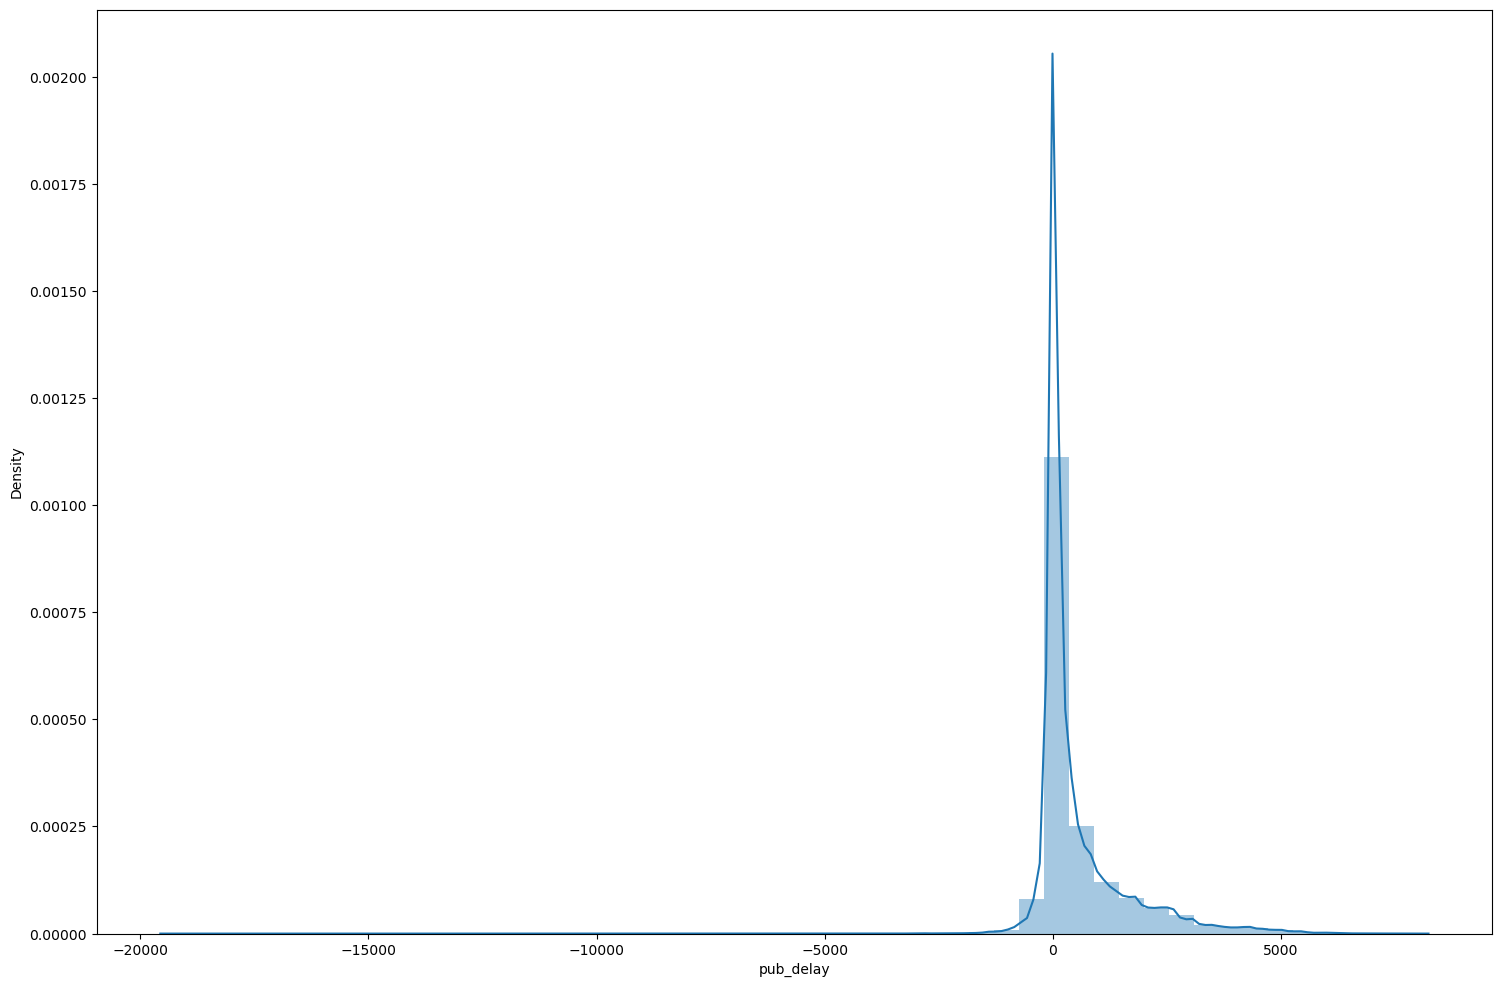

In [11]:
# plot timedelta distribution
fig_dims = (18, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(gens["pub_delay"], ax=ax)

In [12]:
# select only papers in a reasonable timedelta window

DELAY_MIN = -270
DELAY_MAX = 270

gens_filtered = gens.loc[gens["pub_delay"] <= DELAY_MAX, :].loc[
    gens["pub_delay"] >= DELAY_MIN, :
]
gens_filtered

,journal,pmc_ID,accession,converted_accession,repository,Date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,time_public,reuse_count,norm_reuse_count,pmc_date,reuse_role,pub_delay
62903,mSphere,PMC10347838,PRJNA880698,SRP397411,SRA,2023/6/13,2022-09-16,Metopolophium dirhodum,Illumina HiSeq 2500,WGS,500.0,2.390947e+10,public,1.917808,0,0.0,2023-06-13,G,270
932528,J Clin Med,PMC8358774,GSE158847,GSE158847,GEO,2021/6/28,2020-10-01,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,3.876712,0,0.0,2021-06-28,G,270
227452,PLoS Negl Trop Dis,PMC5054024,SRP065916,SRP065916,SRA,2016/9/16,2015-12-21,Zea mays,Illumina HiSeq 2000,RNA-Seq,200.0,2.583644e+09,public,8.660274,0,0.0,2016-09-16,G,270
358946,Front Neurosci,PMC4474661,SRP029217,SRP029217,SRA,2015/5/23,2014-08-26,flower metagenome,Illumina HiSeq 2000,RNA-Seq,99.0,4.112700e+09,public,9.980822,0,0.0,2015-05-23,G,270
358944,Genome Announc,PMC4474661,SRP029217,SRP029217,SRA,2015/5/23,2014-08-26,flower metagenome,Illumina HiSeq 2000,RNA-Seq,99.0,4.112700e+09,public,9.980822,0,0.0,2015-05-23,G,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372773,BMC Dermatol,PMC4176963,GSE59245,GSE59245,GEO,2014/8/21,2015-05-18,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,9.254795,0,0.0,2014-08-21,G,-270
372772,Diabet Med,PMC4176963,GSE59245,GSE59245,GEO,2014/8/21,2015-05-18,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,9.254795,0,0.0,2014-08-21,G,-270
372771,Health Qual Life Outcomes,PMC4176963,GSE59245,GSE59245,GEO,2014/8/21,2015-05-18,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,9.254795,0,0.0,2014-08-21,G,-270
372770,Front Psychol,PMC4176963,GSE59245,GSE59245,GEO,2014/8/21,2015-05-18,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,9.254795,0,0.0,2014-08-21,G,-270


In [13]:
# select random papers inside/outside threshold for QC analysis


# gens_filtered are inside threshold already
# get papers outside threshold, but within 365 days

DELAY_EDGE = 365

gens_aboveThresh = gens.loc[gens["pub_delay"] >= DELAY_MAX, :].loc[
    gens["pub_delay"] <= DELAY_EDGE
]
gens_aboveThresh = gens_aboveThresh.loc[gens_aboveThresh["repository"] == "GEO", :]
gens_belowThresh = gens.loc[gens["pub_delay"] <= DELAY_MIN, :].loc[
    gens["pub_delay"] >= -DELAY_EDGE
]
gens_belowThresh = gens_belowThresh.loc[gens_belowThresh["repository"] == "GEO", :]
gens_insideThresh = gens_filtered.loc[gens_filtered["repository"] == "GEO", :]

num_papers = 50
half_papers = int(num_papers / 2)

# take random samples inside, above, and below threshold
rand_in = pd.DataFrame(random.sample(gens_insideThresh["pmc_ID"].tolist(), num_papers))
rand_in.columns = ["pmc_ID"]
rand_ab = pd.DataFrame(random.sample(gens_aboveThresh["pmc_ID"].tolist(), half_papers))
rand_ab.columns = ["pmc_ID"]
rand_be = pd.DataFrame(random.sample(gens_belowThresh["pmc_ID"].tolist(), half_papers))
rand_be.columns = ["pmc_ID"]

# match accessions to papers to make manual work easier
r_in = pd.merge(
    rand_in, gens_insideThresh[["pmc_ID", "accession"]], on="pmc_ID", how="left"
).drop_duplicates()
r_in["real_introducer"] = np.NaN
r_ab = pd.merge(
    rand_ab, gens_aboveThresh[["pmc_ID", "accession"]], on="pmc_ID", how="left"
).drop_duplicates()
r_be = pd.merge(
    rand_be, gens_belowThresh[["pmc_ID", "accession"]], on="pmc_ID", how="left"
).drop_duplicates()
r_out = pd.concat([r_ab, r_be])
r_out["real_introducer"] = np.NaN

# save incomplete files to csv
r_in.to_csv("../data/random_introducers_inside.csv", index=False)
r_out.to_csv("../data/random_introducers_outside.csv", index=False)

In [14]:
not_gens = allFactors.loc[allFactors['reuse_role'] != 'G', :]
filtered_matrix = pd.concat(objs = [gens_filtered, not_gens], ignore_index = True, sort = False)

In [15]:
lsc = Counter(filtered_matrix.loc[filtered_matrix['repository'] == "SRA", ]["library_strategy"])
lsc_df = pd.DataFrame.from_dict(lsc, orient = 'index').reset_index()
sraLS = list(lsc_df["index"])
sraLS.remove("RNA-Seq")

In [16]:
# add a column for "class"... separating GEO/SRA distinction into:
# (1) GEO gene expression
# (2) RNA-seq (GEO and SRA)
# (3) SRA other omics technologies

key = {
      "repository": ["GEO", "GEO", "SRA"] + ["SRA"] * (len(sraLS)), 
      "library_strategy": ["Expression_Array", "RNA-Seq", "RNA-Seq"] + sraLS,
      "class": ["GEO_expr", "RNA-Seq", "RNA-Seq"] + ["SRA_other"] * (len(sraLS))}
key = pd.DataFrame(key)
key

,repository,library_strategy,class
0,GEO,Expression_Array,GEO_expr
1,GEO,RNA-Seq,RNA-Seq
2,SRA,RNA-Seq,RNA-Seq
3,SRA,WGS,SRA_other
4,SRA,AMPLICON,SRA_other
5,SRA,OTHER,SRA_other
6,SRA,RAD-Seq,SRA_other
7,SRA,Targeted-Capture,SRA_other
8,SRA,ChIP-Seq,SRA_other
9,SRA,miRNA-Seq,SRA_other


In [17]:
filtered_matrix = pd.merge(filtered_matrix, key, how = 'left', on = ['repository', 'library_strategy'])
filtered_matrix

,journal,pmc_ID,accession,converted_accession,repository,Date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,time_public,reuse_count,norm_reuse_count,pmc_date,reuse_role,pub_delay,class
0,mSphere,PMC10347838,PRJNA880698,SRP397411,SRA,2023/6/13,2022-09-16,Metopolophium dirhodum,Illumina HiSeq 2500,WGS,500.0,2.390947e+10,public,1.917808,0,0.000000,2023-06-13,G,270.0,SRA_other
1,J Clin Med,PMC8358774,GSE158847,GSE158847,GEO,2021/6/28,2020-10-01,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,3.876712,0,0.000000,2021-06-28,G,270.0,RNA-Seq
2,PLoS Negl Trop Dis,PMC5054024,SRP065916,SRP065916,SRA,2016/9/16,2015-12-21,Zea mays,Illumina HiSeq 2000,RNA-Seq,200.0,2.583644e+09,public,8.660274,0,0.000000,2016-09-16,G,270.0,RNA-Seq
3,Front Neurosci,PMC4474661,SRP029217,SRP029217,SRA,2015/5/23,2014-08-26,flower metagenome,Illumina HiSeq 2000,RNA-Seq,99.0,4.112700e+09,public,9.980822,0,0.000000,2015-05-23,G,270.0,RNA-Seq
4,Genome Announc,PMC4474661,SRP029217,SRP029217,SRA,2015/5/23,2014-08-26,flower metagenome,Illumina HiSeq 2000,RNA-Seq,99.0,4.112700e+09,public,9.980822,0,0.000000,2015-05-23,G,270.0,RNA-Seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114244,Eur Urol Open Sci,PMC11260452,ERR195223,ERP001824,SRA,NaN,2013-01-18,Homo sapiens,Illumina Genome Analyzer IIx,OTHER,20.0,2.481880e+06,public,11.583562,9,0.776963,NaT,R,NaN,SRA_other
1114245,Cureus,PMC11260452,ERR195224,ERP001824,SRA,NaN,2013-01-18,Homo sapiens,Illumina Genome Analyzer IIx,OTHER,20.0,2.481880e+06,public,11.583562,9,0.776963,NaT,R,NaN,SRA_other
1114246,ESMO Open,PMC11260452,GSM495500,GSE19836,GEO,NaN,2010-12-06,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,13.704110,13,0.948621,NaT,R,NaN,GEO_expr
1114247,Cureus,PMC11260452,GSM495500,GSE19836,GEO,NaN,2010-12-06,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,13.704110,13,0.948621,NaT,R,NaN,GEO_expr


In [18]:
# what are the SRA library strategies?
lc = Counter(filtered_matrix.loc[filtered_matrix["repository"] == "SRA", :]["library_strategy"])
libCntr = pd.DataFrame.from_dict(lc, orient = "index")
libCntr.to_csv("../data/sra_library_strategies.csv", header = False)

In [19]:
# how much data coverage do we get when using the class column?
Counter(filtered_matrix['class'])

Counter({'SRA_other': 187315,
         'RNA-Seq': 288297,
         'GEO_expr': 498227,
         nan: 140410})

In [20]:
filtered_matrix.to_csv('../data/metadata_matrix_filtered.csv', index = False)